In [1]:
import pandas as pd
import numpy as np

# Drawing Map

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

# 1. Reading Calgary Boundary from City_Boundary_Layer

In [50]:
# reading csv file containing the coordinates of calgary city
df_boundary = pd.read_csv('City_Boundary_layer.csv')

# reading coordinates and refining them
df_coordinates = df_boundary['the_geom']
df_cord = df_coordinates[0][10:].replace(")","")
df_cord_split = df_cord.split(",")

# list of longitudes
lons = [float((x.strip().split())[0]) for x in df_cord_split]

# list of latitudes
lats = [float((x.strip().split())[1]) for x in df_cord_split]

# min and max latitude and longitude values
long_max = max(lons)
long_min = min(lons)
lat_max = max(lats)
lat_min = min(lats)

# coordinates for drawing boundary of calgary
ls = ((lat_max,long_max),(lat_max,long_min),(lat_min,long_min),(lat_min,long_max),(lat_max,long_max))

# central location of calgary city
locat = [51.049999, -114.066666]

# displays the map of Calgary city
m = folium.Map(location = locat, zoom_start=10)

# adding boundary coordinates to the map and then displaying it
folium.PolyLine(ls, color="red", weight=2.5, opacity=1).add_to(m)
m

# 3. Divide calgary to a 10x10 matrix of areas. 

In [52]:
# dividing into grids
vertical_cord_upper = []
vertical_cord_lower = []
horizontal_cord_left = []
horizontal_cord_right = []

# calculating the coordinates for creating the grids
for i in range(1, 10):
    # calculating the longitude after each iteration
    long = long_min + (i*(long_max - long_min)/10)
    # calculating the latitude after each iteration
    lat = lat_min + (i*(lat_max - lat_min)/10)
    # appending the coordinates for each iteration
    vertical_cord_upper.append((lat_max,long))
    vertical_cord_lower.append((lat_min,long))
    horizontal_cord_left.append((lat, long_min))
    horizontal_cord_right.append((lat, long_max))
    horizontal_cord_right
    
# plotting the grids
for i in range(0,9):
    vertical_cord = []
    horizontal_cord = []
    # calculating the coordinates for drawing the vertical and the horizontal lines
    vertical_cord.append(vertical_cord_upper[i])
    vertical_cord.append(vertical_cord_lower[i])
    horizontal_cord.append(horizontal_cord_left[i])
    horizontal_cord.append(horizontal_cord_right[i])
    # drawing a vertical line
    folium.PolyLine(vertical_cord, color="brown", weight=1, opacity=1).add_to(m)
    # drawing a horizontal line
    folium.PolyLine(horizontal_cord, color="brown", weight=1, opacity=1).add_to(m)

# displaying the map
m


# 4. For each grid calculate the various features

In [7]:
# getting the coordinates of all the grids and storing them in a list
# coordinates are stored as a list of tuples in grid_cord
# Each tuple contains 4 values for lat min, lat max, long min, and long max

# list for storing the coordinates
grid_cord = []
lat_grid_min = lat_min
long_grid_min = long_min
lat_grid_max = 0
long_grid_max = 0

# looping through the rows of the grids
for i in range (1,11):
    # calculating the latitude for particular row of grids
    lat_grid_max = lat_grid_min + ((lat_max - lat_min)/10)
    long_grid_min = long_min
    
    # looping through the columns of the grids
    for j in range (1,11):
        long_grid_max = long_grid_min + ((long_max - long_min)/10)
        
        # appending the coordinated for that particular grids
        grid_cord.append((lat_grid_min,lat_grid_max,long_grid_min,long_grid_max))
        long_grid_min = long_grid_max
    lat_grid_min = lat_grid_max

Feature 1 : Counting number of cameras in each grid

In [53]:
# counting no of cameras in each grid

# reading csv file for cameras
df_camera = pd.read_csv("Traffic_Camera_Locations.csv")

# dictionary for storing the values
dict_data = {}

# column for adding the number of cameras in each grid
dict_data['num_cameras']= []

# algo for counting the number of cameras in each grid 

# coordinates of each grid
for i in grid_cord:
    
    # checking if the coordinates lie in that grid
    bool_Series = df_camera['latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_camera['longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    
    # getting data corresponding to the coordinates that lie in that grid
    df_camera_filter = df_camera[bool_Series] 

    # appending num of cameras for that grid
    dict_data['num_cameras'].append(df_camera_filter.shape[0])

Feature 2: Calculating Average Speed for each grid

In [54]:
# Reading the speed limits and refining the data for 2018

# reading speed limits
df_speed_all = pd.read_csv("Speed_Limits.csv")

# parsing date
df_speed_all['CREATED_DT'] = pd.to_datetime(df_speed_all['CREATED_DT'], format = '%Y-%m-%d')

# filtering data for year 2018
df_speed = df_speed_all[df_speed_all['CREATED_DT'].dt.year == 2018]

# remove own index with default index 
df_speed.reset_index(inplace = True, drop = True)

# df_speed_loc has only speeds and location coordinates
df_speed_loc = df_speed[['SPEED','multiline']]

# removing extra characters from location
df_speed_loc['multiline'] = df_speed_loc['multiline'].apply(lambda x: x[16:].replace("(","").replace(")",""))

# checks for NAN values
df_speed_loc.isnull().any()

# creating lists for latitude, longitude, and speed for 'speed data'
speed_lat_ls =[]
speed_long_ls = []
speed_ls = []

# algo for getting lats, longs, and speed
for i in range (df_speed_loc.shape[0]):
    coordinates = df_speed_loc.loc[i,'multiline'].split(",")
    for j in coordinates:
        cord_space = j.split()
        speed_long_ls.append(cord_space[0])
        speed_lat_ls.append(cord_space[1])
        speed_ls.append(df_speed_loc.loc[i,'SPEED'])


C:\Users\Hp-user\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating average speeds for each grid

In [55]:
# counting average speed in each grid
pd.set_option('display.max_rows', 500)

dict_speed = {'Speed':speed_ls, 'Latitude':speed_lat_ls, 'Longitude':speed_long_ls}

# creating new data frame for speed with lats, longs, and speeds 
df_speed_new = pd.DataFrame.from_dict(dict_speed)
df_speed_new = df_speed_new.astype(float)
avg_speed_ls = []

#i iterates through all the grids
for i in grid_cord:
    
    # checks if coordinate lies in particular grid
    bool_Series = df_speed_new['Latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_speed_new['Longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    
    # getting data corresponding to the coordinates that lie in that grid
    df_speed_new_filter = df_speed_new[bool_Series]
    
    # calculating average of the volumes
    avg_speed_ls.append(df_speed_new_filter['Speed'].mean())
dict_data['avg_speed'] = avg_speed_ls

Feature 3: Calculating Average Volumes

In [56]:
# reading volume file
traffic_vol_csv_all = pd.read_csv("Traffic_Volumes_for_2018.csv")

# filtering data for year 2018
traffic_vol_csv = traffic_vol_csv_all[traffic_vol_csv_all['YEAR'] == 2018]

# remove own index with default index 
traffic_vol_csv.reset_index(inplace = True, drop = True)

# refining data in multilinestring to fetch individual coordinates
traffic_vol_csv['multilinestring'] = traffic_vol_csv['multilinestring'].apply(lambda x: x[16:].replace("(","").replace(")",""))

# creating lists for latitude, longitude, and volume for 'traffic_vol_csv'
vol_lat_list =[]
vol_long_list = []
vol_list = []

# algo for getting lats, longs, and speed
for i in range (traffic_vol_csv.shape[0]):
    coordinates = traffic_vol_csv.loc[i,'multilinestring'].split(",")
    for j in coordinates:
        cord_space = j.split()
        vol_long_list.append(float(cord_space[0]))
        vol_lat_list.append(float(cord_space[1]))
        vol_list.append(float(traffic_vol_csv.loc[i,'VOLUME']))

C:\Users\Hp-user\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Finding average volumes for each grid

In [57]:
df_volume_new = pd.DataFrame({'Volume':vol_list, 'Latitude':vol_lat_list, 'Longitude':vol_long_list})

# list containing average values of volume for all grids
volume_grid_ls = []

#algo for finding the average
#i iterates through all the grids
for i in grid_cord:
    
    # checks if coordinate lies in particular grid
    bool_Series = df_volume_new['Latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_volume_new['Longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    
    # getting data corresponding to the coordinates that lie in that grid
    df_volume_new_filter = df_volume_new[bool_Series]
    
    # calculating average of the volumes
    volume_grid_ls.append(df_volume_new_filter['Volume'].mean()) 
    
dict_data['avg_volume'] = volume_grid_ls

Feature 4: Finding traffic signals for each grid

In [60]:
# reading traffic signals file
df_signals_all = pd.read_csv("Traffic_Signals.csv")

# PARSING DATE
df_signals_all['INSTDATE'] = pd.to_datetime(df_signals_all['INSTDATE'], format = '%Y-%m-%d')

# filtering data for year 2018
df_signals = df_signals_all[df_signals_all['INSTDATE'].dt.year == 2018]

# remove own index with default index 
df_signals.reset_index(inplace = True, drop = True)

# list for appending number of signals in each grid
ls = []

# iterating through grids
for i in grid_cord:
    # checking the latitue and longitudes
    bool_Series = df_signals['latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_signals['longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    # getting the list of signals for a grid that is being iterated
    df_sig = df_signals[bool_Series]
    # appending the count of signals for a grid that is being iterated
    ls.append(df_sig.shape[0])

# adding signal data to the list
dict_data['num_signal'] = ls

Feature 5: Finding Traffic Signs for each grid

In [70]:
# reading signs.csv file
df_signs = pd.read_csv("Traffic_Signs.csv")

# accessing the coordinates and signs
df_signs = df_signs[['BLADE_TYPE','POINT']]

# refining the coordinate data
df_signs['POINT'] = df_signs['POINT'].apply(lambda x: x[7:].replace(")",""))

# filtering empty rows
df_signs['BLADE_TYPE'].replace('', np.nan, inplace=True)
df_signs.dropna(subset=['BLADE_TYPE'], inplace=True)

# creating latitude and longitude from point
df_signs['latitude'] = df_signs['POINT'].apply(lambda x: x.split()[1])
df_signs['latitude'] = df_signs['latitude'].astype(float)
df_signs['longitude'] = df_signs['POINT'].apply(lambda x: x.split()[0])
df_signs['longitude'] = df_signs['longitude'].astype(float)

# list for appending number of signs in each grid
ls_signs = []

# iterating through grids
for i in grid_cord:
    # checking the latitue and longitudes
    bool_Series = df_signs['latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_signs['longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    # getting the list of signs for a grid that is being iterated
    df_sig = df_signs[bool_Series]
    # appending the count of signs for a grid that is being iterated
    ls_signs.append(df_sig.shape[0])

# adding data for traffic signs to the dictionary
dict_data['num_signs'] = ls_signs

Feature 6 : Calculating average number of incidents for each grid

In [62]:
# reading csv file
df_incident_all = pd.read_csv("Traffic_Incidents.csv", parse_dates = ['START_DT'])

# filtering data for year 2018
df_incident = df_incident_all[df_incident_all['START_DT'].dt.year == 2018]

# remove own index with default index 
df_incident.reset_index(inplace = True, drop = True)

# list for appending number of accidents in each grid
ls_incident = []

# iterating through grids
for i in grid_cord:
    # checking the latitue and longitudes
    bool_Series = df_incident['Latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_incident['Longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    # getting the list of accidents for a grid that is being iterated
    df_acc = df_incident[bool_Series]
    # appending the count of accidents for a grid that is being iterated
    ls_incident.append(df_acc.shape[0])

dict_data['num_accidents'] = ls_incident

Creating data frame and printing it

In [75]:
# adding location coordinates to the dictionary
dict_data['cell_bounds'] = grid_cord

# creating and displaying data frame
df = pd.DataFrame(dict_data)
df = df.replace(np.nan, 0)
df


,num_cameras,avg_speed,avg_volume,num_signal,num_signs,num_accidents,cell_bounds
0,0,0.000000,0.000000,0,0,0,"(50.842822, 50.8797823, -114.315796, -114.2702..."
1,0,0.000000,0.000000,0,0,0,"(50.842822, 50.8797823, -114.2702069, -114.224..."
2,0,0.000000,0.000000,0,0,0,"(50.842822, 50.8797823, -114.2246178, -114.179..."
3,0,0.000000,0.000000,0,0,0,"(50.842822, 50.8797823, -114.1790287, -114.133..."
4,0,0.000000,2000.000000,0,54,0,"(50.842822, 50.8797823, -114.1334396, -114.087..."
5,1,55.063291,2509.433962,0,303,7,"(50.842822, 50.8797823, -114.0878505, -114.042..."
6,1,70.557621,11914.826498,0,1486,17,"(50.842822, 50.8797823, -114.0422614, -113.996..."
7,0,80.445545,17805.128205,0,753,13,"(50.842822, 50.8797823, -113.9966723, -113.951..."
8,0,0.000000,0.000000,0,27,0,"(50.842822, 50.8797823, -113.9510832, -113.905..."
9,0,0.000000,0.000000,0,5,0,"(50.842822, 50.8797823, -113.9054941, -113.859..."


# Analysing weather conditions
Weather conditions are calculated for the year 2018. The weather condition is considered same through out the calgary city.

In [77]:
# function for reading the calgary weather data

def download_weather_data(station, year, month=1, daily=True):
    """ returns a DataFrame with weather data from climate.weather.gc.ca"""
   # url string with variables station, year and month
    url_template = "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station}&Year={year}&Month={month}&Day=14&timeframe={time_frame}&submit=Download+Data"

    # replace variables in string with actual values
    if daily:
        url = url_template.format(station = station, year = year, month = month, time_frame = 2)
    else:
        url = url_template.format(station= station, year = year, month = month, time_frame = 1)

    # read data into dataframe, use headers and set Date/Time column as index
    weather_data = pd.read_csv(url, index_col='Date/Time', parse_dates=True)

    # replace the degree symbol in the column names
    weather_data.columns = [col.replace('\xb0', '') for col in weather_data.columns]
    
    return (weather_data)

In [80]:
# fetching the hourly weather data for year 2018 and creating the dataframe for the same
df_weather = download_weather_data(station=50430, year=2018, month=1, daily = False)

# fetching data for all the months
for i in range(2,13):
    df_weather1 = download_weather_data(station=50430, year=2018, month=i, daily = False)
    # appending data to data frame
    df_weather = pd.concat([df_weather,df_weather1])
    
# accessing visibility, temp, and date/time
df_weather_cleaned = df_weather[['Temp (C)','Visibility (km)']]
df_weather_cleaned.reset_index(inplace = True)
df_weather_cleaned.head(10)

,Date/Time,Temp (C),Visibility (km)
0,2018-01-01 00:00:00,-28.1,24.1
1,2018-01-01 01:00:00,-28.6,24.1
2,2018-01-01 02:00:00,-29.1,24.1
3,2018-01-01 03:00:00,-30.0,24.1
4,2018-01-01 04:00:00,-27.6,24.1
5,2018-01-01 05:00:00,-27.1,24.1
6,2018-01-01 06:00:00,-26.6,24.1
7,2018-01-01 07:00:00,-22.7,24.1
8,2018-01-01 08:00:00,-22.3,64.4
9,2018-01-01 09:00:00,-19.8,64.4


In [81]:
# Computing daily visibilty and temperature from the hourly data

# resampling the data on date/time for getting daily values
df_weather_cleaned_sample = df_weather_cleaned.resample('D', on='Date/Time').mean()
df_weather_cleaned_sample.reset_index(inplace=True)
df_weather_cleaned_sample.head()

# maerging the weather data with accident count based on dates
df_weather_cleaned_sample = df_weather_cleaned_sample.reset_index()
df_merged_acc_weather = pd.merge(df_accidents_sample, df_weather_cleaned_sample, left_on = 'Date', right_on = 'Date/Time')

df_merged_acc_weather_final = df_merged_acc_weather[['Date','Count','Temp (C)','Visibility (km)']]
df_merged_acc_weather_final.head(10)


,Date,Count,Temp (C),Visibility (km)
0,2018-01-01,12,-16.683333,42.570833
1,2018-01-02,30,-3.787500,40.891667
2,2018-01-03,26,-2.391667,39.212500
3,2018-01-04,22,-5.016667,40.891667
4,2018-01-05,20,-0.345833,40.891667
5,2018-01-06,10,3.666667,39.550000
6,2018-01-07,6,-0.166667,40.020833
7,2018-01-08,10,1.475000,39.212500
8,2018-01-09,14,-9.854167,16.370833
9,2018-01-10,30,-21.625000,10.587500


# @neha start from here and delete this cell

In [76]:
# reassembling accidents data count for each day

df_accidents_cleaned = df_incident[['START_DT','Count']]
df_accidents_cleaned['Date'] = pd.to_datetime(df_accidents_cleaned['START_DT'])
df_accidents_sample = df_accidents_cleaned.resample('D', on='Date').sum()
df_accidents_sample.reset_index(inplace=True)
df_accidents_sample = df_accidents_sample[df_accidents_sample['Date'].between('2018-01-01', '2018-12-31', inclusive = True)]
df_accidents_sample


C:\Users\Hp-user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Date,Count
0,2018-01-01,12
1,2018-01-02,30
2,2018-01-03,26
3,2018-01-04,22
4,2018-01-05,20
5,2018-01-06,10
6,2018-01-07,6
7,2018-01-08,10
8,2018-01-09,14
9,2018-01-10,30


# drawing heat map of accident data , might drop it

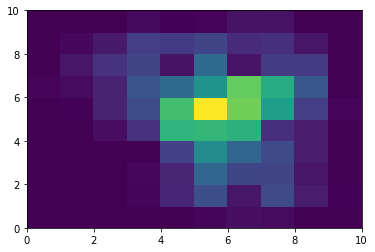

In [21]:
index = ['0', '1', '2', '3', '4','5','6','7','8','9']
columns = ['0', '1', '2', '3', '4','5','6','7','8','9']
#x = np.reshape(list_data, (100, 28)).T
list_accidents = list(df['num_accidents'])
np_list = np.reshape(list_accidents, (10, 10))
df_plot_accident = pd.DataFrame(np_list, index=index, columns=columns)

plt.pcolor(df_plot_accident)
plt.show()

# drawing heat map of avg_volume, drop


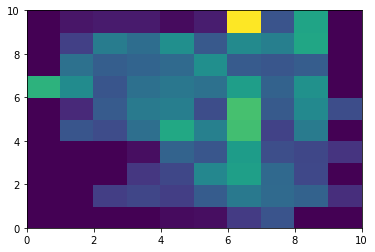

In [82]:
index = ['0', '1', '2', '3', '4','5','6','7','8','9']
columns = ['0', '1', '2', '3', '4','5','6','7','8','9']
#x = np.reshape(list_data, (100, 28)).T
list_volume_heat = list(df['avg_volume'])
np_list_volume = np.reshape(list_volume_heat, (10, 10))
df_plot_volume = pd.DataFrame(np_list_volume, index=index, columns=columns)

plt.pcolor(df_plot_volume)
plt.show()

# Analysis of accident with cameras

Text(0, 0.5, 'Number of accidents')

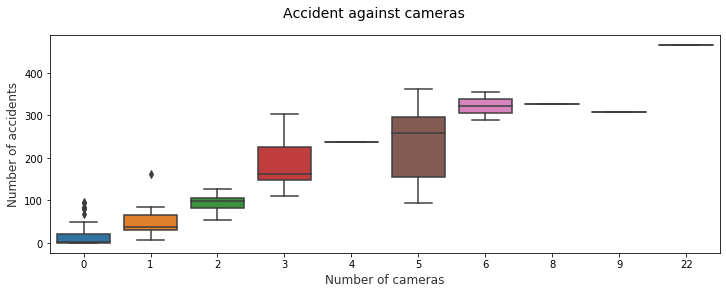

In [23]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Accident against cameras', fontsize=14)

sns.boxplot(x="num_cameras", y="num_accidents", data=df,  ax=ax)
ax.set_xlabel("Number of cameras",size = 12,alpha=0.8)
ax.set_ylabel("Number of accidents",size = 12,alpha=0.8)

# Analysis of accident with volume

Text(0, 0.5, 'Number of accidents')

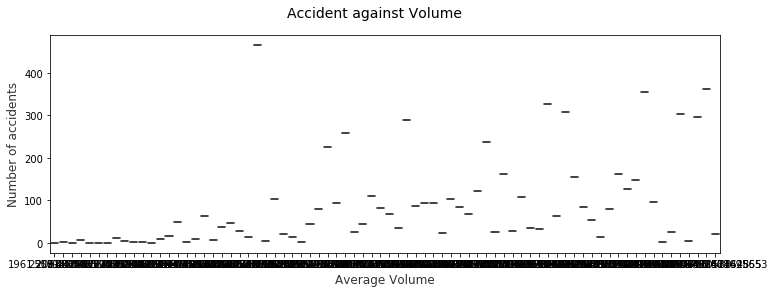

In [24]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Accident against Volume', fontsize=14)

sns.boxplot(x="avg_volume", y="num_accidents", data=df,  ax=ax)
ax.set_xlabel("Average Volume",size = 12,alpha=0.8)
ax.set_ylabel("Number of accidents",size = 12,alpha=0.8)

No handles with labels found to put in legend.


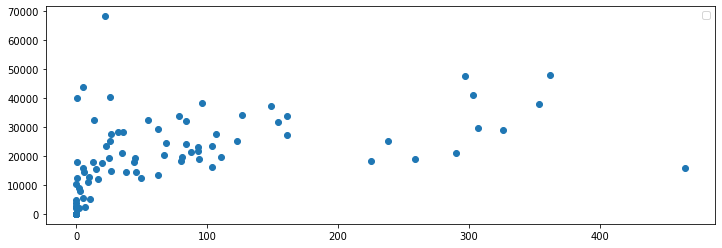

In [25]:
#fig = plt.figure()
fig,ax = plt.subplots(figsize=(12,4))
#ax = fig.add_subplot(111)

ax.scatter(y=df['avg_volume'], x=df['num_accidents'])

plt.legend(loc='upper right')

plt.show()

# Analysis of accident with signs

Text(0, 0.5, 'Number of accidents')

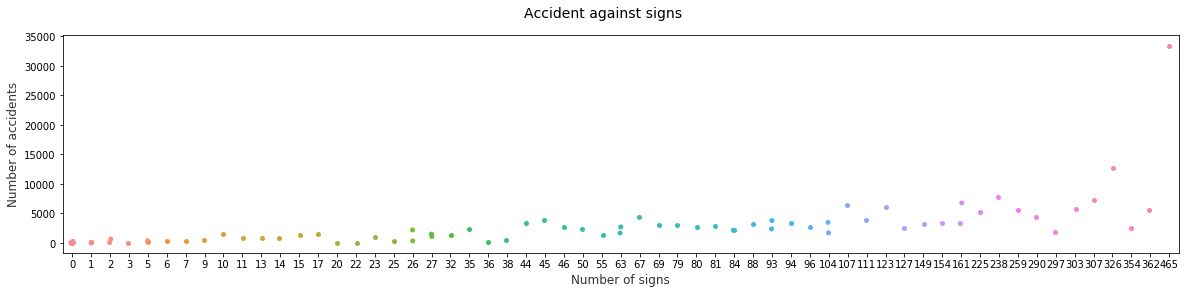

In [26]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(20, 4))
f.suptitle('Accident against signs', fontsize=14)
sns.stripplot(y="num_signs", x="num_accidents", data=df,  jitter=0.05)
ax.set_xlabel("Number of signs",size = 12,alpha=0.8)
ax.set_ylabel("Number of accidents",size = 12,alpha=0.8)

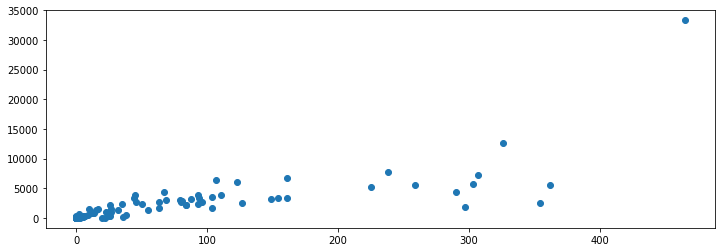

In [27]:
#fig = plt.figure()
fig,ax = plt.subplots(figsize=(12,4))
#ax = fig.add_subplot(111)

ax.scatter(y=df['num_signs'], x=df['num_accidents'])

#plt.legend(loc='upper right')

plt.show()

# Analysis of accident with signals

Text(0, 0.5, 'Number of accidents')

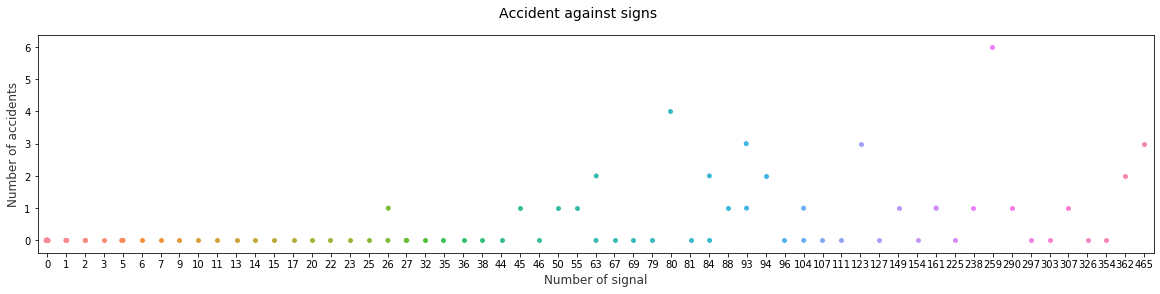

In [28]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(20, 4))
f.suptitle('Accident against signs', fontsize=14)
sns.stripplot(y="num_signal", x="num_accidents", data=df,  jitter=0.05)
ax.set_xlabel("Number of signal",size = 12,alpha=0.8)
ax.set_ylabel("Number of accidents",size = 12,alpha=0.8)

Text(0, 0.5, 'Number of accidents')

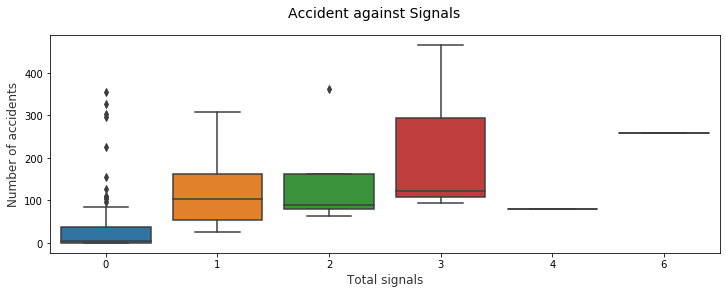

In [29]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Accident against Signals', fontsize=14)

sns.boxplot(x="num_signal",y="num_accidents", data=df,  ax=ax)
ax.set_xlabel("Total signals",size = 12,alpha=0.8)
ax.set_ylabel("Number of accidents",size = 12,alpha=0.8)

In [33]:
df_merged_acc_weather_final.head()

,Date,Count,Temp (C),Visibility (km)
0,2018-01-01,12,-16.683333,42.570833
1,2018-01-02,30,-3.787500,40.891667
2,2018-01-03,26,-2.391667,39.212500
3,2018-01-04,22,-5.016667,40.891667
4,2018-01-05,20,-0.345833,40.891667


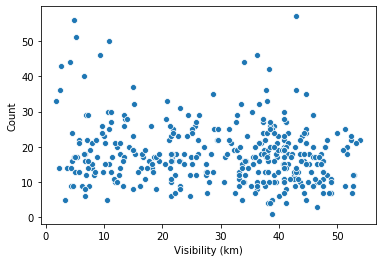

In [34]:
# scatterplot for visibility

sns.scatterplot(x=df_merged_acc_weather_final['Visibility (km)'], y=df_merged_acc_weather_final['Count'], data=df_merged_acc_weather_final)

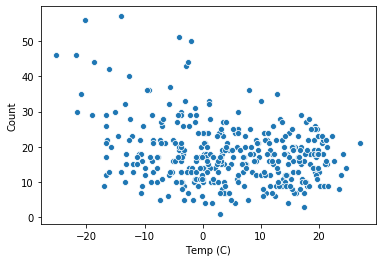

In [35]:
# scatterplot for temp


sns.scatterplot(x=df_merged_acc_weather_final['Temp (C)'], y=df_merged_acc_weather_final['Count'], data=df_merged_acc_weather_final)

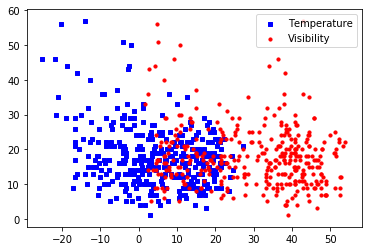

In [36]:
# combined scatter plot

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=df_merged_acc_weather_final['Temp (C)'], y=df_merged_acc_weather_final['Count'], s=10, c='b', marker="s", label='Temperature')
ax1.scatter(x=df_merged_acc_weather_final['Visibility (km)'], y=df_merged_acc_weather_final['Count'], s=10, c='r', marker="o", label='Visibility')
plt.legend(loc='upper right');
plt.show()

# Analysis for Number of Accidents and Speed limit

In [37]:
# dataframe of speed and date
df_speed_cleaned = df_speed[['CREATED_DT','SPEED']]

# resampling df_speed_cleaned dataframe for average speed for each date in year 2018
df_speed_cleaned_avg = df_speed_cleaned.groupby(['CREATED_DT']).mean()

In [38]:
# merging speed and traffic incidents data
df_merged_acc_speed = pd.merge(df_speed_cleaned_avg, df_accidents_sample, left_on = 'CREATED_DT', right_on = 'Date', how='inner')
df_merged_acc_speed_rounded = df_merged_acc_speed.round({"SPEED":1})
df_merged_acc_speed_rounded

,SPEED,Date,Count
0,67.8,2018-10-17,35
1,63.1,2018-10-23,25
2,63.6,2018-10-25,18
3,67.1,2018-10-28,4
4,53.9,2018-10-29,25
5,55.7,2018-10-30,24
6,57.2,2018-10-31,19
7,66.8,2018-11-02,16
8,78.5,2018-11-07,22
9,77.0,2018-12-06,26


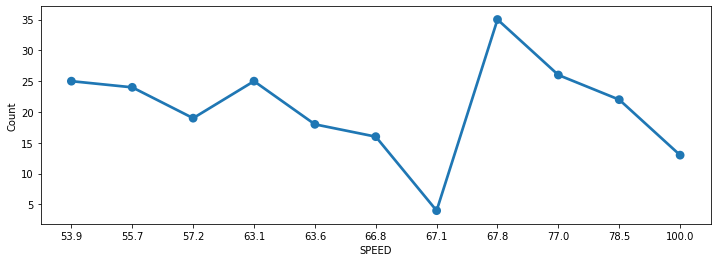

In [39]:
fig,ax = plt.subplots(figsize=(12,4))

sns.pointplot(x='SPEED', y='Count',   data=df_merged_acc_speed_rounded, )

# ax.set_xticks(range(0,10))
# ax.set_xticklabels(range(0,100))
plt.show()


# Finding spearman correlation

Spearman coefficient for cameras and accidents

In [90]:
# for accident and cameras spearman coeffcient

# getting columns of accidents and cameras
df_acc_cameras = df[['num_cameras', 'num_accidents']]
df_acc_cameras.dropna(inplace = True)

camera_correlation = df_acc_cameras.corr(method ='spearman')
camera_correlation = camera_correlation['num_accidents'][0]

C:\Users\Hp-user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Calculating the spearman coefficient between the speed and the accidents

In [86]:
# for accident and speed spearman coeffcient
# getting columns of accidents and speed
df_acc_speed = df[['avg_speed', 'num_accidents']]
df_acc_speed = df_acc_speed.replace(0, np.nan)
df_acc_speed.dropna(inplace = True)

speed_correlation = df_acc_speed.corr(method ='spearman')
speed_correlation = speed_correlation['num_accidents'][0]

calculating the spearman coefficient between the signs and the accidents

In [91]:
# for accident and sign spearman coeffcient
# getting columns of accidents and signs
df_acc_sign = df[['num_signs', 'num_accidents']]
df_acc_sign = df_acc_sign.replace(0, np.nan)
df_acc_sign.dropna(inplace = True)

sign_correlation = df_acc_sign.corr(method ='spearman')
sign_correlation = sign_correlation['num_accidents'][0]



calculating the spearman coefficient between the signals and the accidents

In [93]:
# for accident and speed spearman coeffcient
# getting columns of accidents and cameras
df_acc_signal = df[['num_signal', 'num_accidents']]
df_acc_signal.dropna(inplace = True)

signal_correlation = df_acc_signal.corr(method ='spearman')
signal_correlation = signal_correlation['num_accidents'][0]


C:\Users\Hp-user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0.550450740145992

calculating the spearman coefficient between the volume and the accidents

In [101]:
# for accident and volume spearman coeffcient
# getting columns of accidents and volumes
df_acc_vol = df[['avg_volume', 'num_accidents']]
#df_acc_vol = df_acc_vol.replace(0, np.nan)
df_acc_vol.dropna(inplace = True)

volume_correlation = df_acc_vol.corr(method ='spearman')
volume_correlation = volume_correlation['num_accidents'][0]

C:\Users\Hp-user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [102]:
# printing the spear man coefficient
print("The spearman coefficient between the volume and the accidents are coefficient : " + str(volume_correlation))
print("The spearman coefficient between the signal and the accidents are coefficient : " + str(signal_correlation))
print("The spearman coefficient between the sign and the accidents are coefficient : " + str(sign_correlation))
print("The spearman coefficient between the speed and the accidents are coefficient : " + str(speed_correlation))
print("The spearman coefficient between the cameras and the accidents are coefficient : " + str(camera_correlation))

The spearman coefficient between the volume and the accidents are coefficient : 0.810734078755483
The spearman coefficient between the signal and the accidents are coefficient : 0.550450740145992
The spearman coefficient between the sign and the accidents are coefficient : 0.8661947875425979
The spearman coefficient between the speed and the accidents are coefficient : -0.30244249000362833
The spearman coefficient between the cameras and the accidents are coefficient : 0.8006178167759678
